#Full Transformer

In [ ]:
!pip3 install transformers
!pip3 install einops

Import everything we need, and get the tokenizer from Huggingface.

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

Here is the MLP class.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

Here is one multihead attention layer. Fill in the missing parts. For reference, the multihead attention layer looks like this. 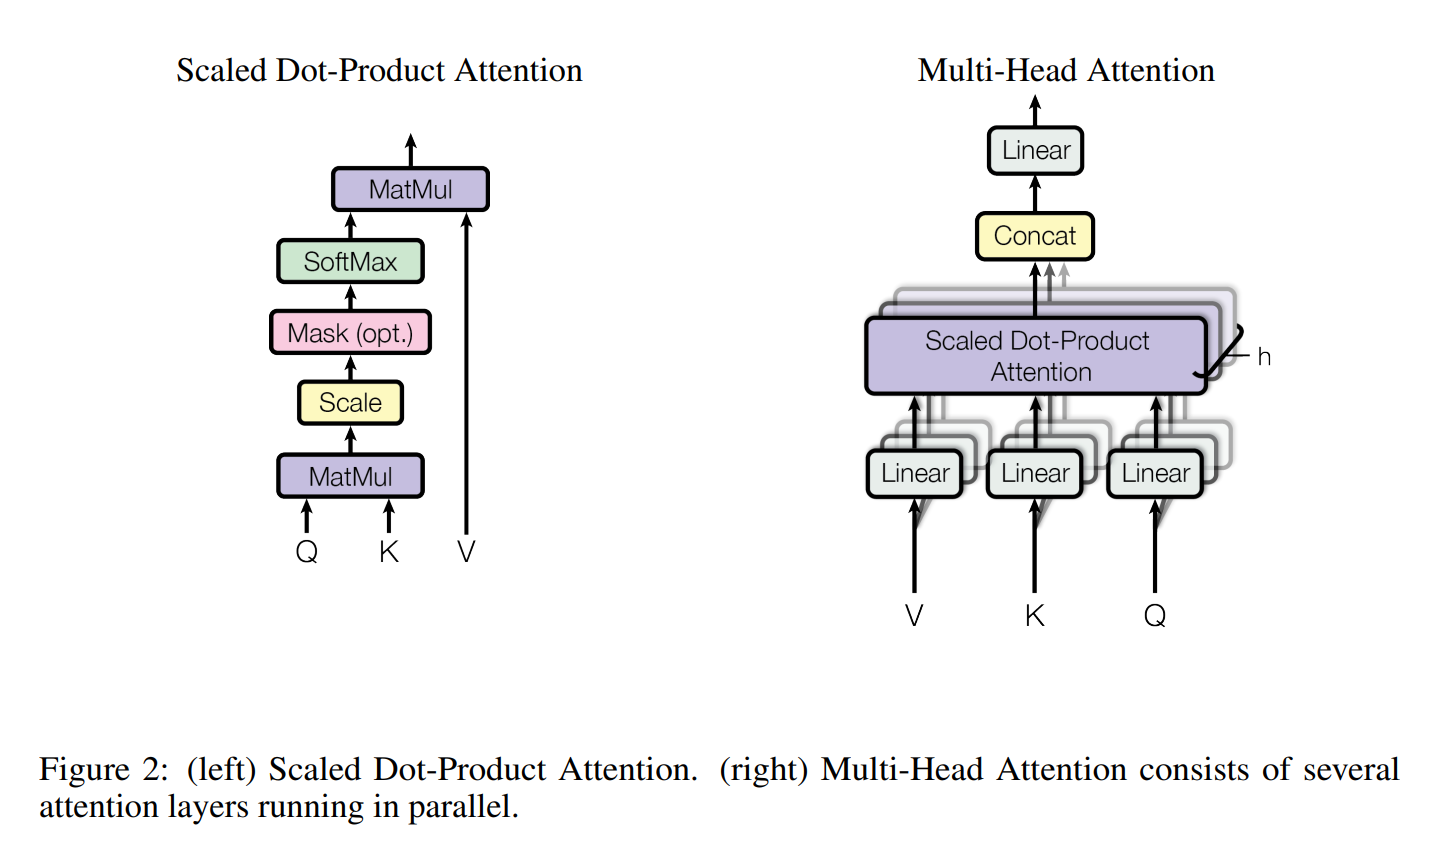

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        # TODO: Implement Multi Head Attention

        # # Solution:
        # qkv = # Convert x to the qkv matrix
        # q, k, v = # split the qkv matrix into query, key, and value vectors
        # # the shapes of the vectors should be (batch, timestep, num_heads, head dim)

        # dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # attn = self.attend(dots)

        # out = torch.matmul(attn, v)
        # out = rearrange(out, 'b h n d -> b n (h d)')

        # return self.to_out(out)
        # # End Solution

Now, it's time to put everything together.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_tokens, dim)
        self.PE = nn.Parameter(torch.randn(1, 1024, dim))
        self.layers = nn.ModuleList([])
        self.output = # TODO: Make the output linear layer

        self.softmax = nn.Softmax(dim=-1)
        for _ in range(depth):
            # TODO: Construct the list of attention heads and feedforward layers, plus normalization
            # To access the Layer Norm module in PyTorch, use this:
            # nn.LayerNorm(dim)


    def forward(self, x):
        b, t, f = x.shape
        x = x + self.PE[:, :t, :]
        for attn, norm1, feedforward, norm2 in self.layers:
            # TODO: Pass x through the necesary layers

        x = self.norm(x)
        x = # TODO: convert the tensor into output probabilities
        return x

    def embed(self, x):
      return self.embedding_layer(x)

Time to test your transformer.

In [ ]:
sentence = "Hello!"
model = Transformer(30000, 64, 8, 8, 8, 64)
tokens = tokenizer(sentence)
tokens = torch.tensor(tokens["input_ids"]).unsqueeze(0)
embeddings = model.embed(tokens)
outputs = model(embeddings)
print(outputs.shape)

torch.Size([1, 30000])


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text, seq_length, tokenizer):
        self.text = text
        tokens = tokenizer(self.text)
        print(tokens)
        self.tokens = torch.tensor(tokens["input_ids"])
        self.seq_length = seq_length

    def __len__(self):
        # break the text into chunks of length seq_length+1, +1 because for the seq len, you predict the next token which includes the seq len+1
        return len(self.tokens)//(self.seq_length+1)

    def __getitem__(self, idx):
        input_seq = self.tokens[idx:idx+self.seq_length]
        target_seq = self.tokens[idx+1:idx+self.seq_length+1]
        return input_seq, target_seq

In [ ]:
import requests

# Download toy data (Shakespeare sonnets)
url = "https://www.gutenberg.org/files/1041/1041-0.txt"
response = requests.get(url)
text = response.text.split("THE SONNETS", 1)[1].split("End of the Project Gutenberg EBook", 1)[0]




In [ ]:
# Prepare the dataset
seq_length = 1024
dataset = TextDataset(text, seq_length, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
def train(model, dataloader, epochs, optimizer, loss_fn):
    model.train()
    for epoch in range(epochs):
        for input_seq, target_seq in dataloader:
            print(input_seq.shape)
            optimizer.zero_grad()
            output = model(input_seq)
            loss = loss_fn(output, target_seq)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")